In [22]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
import cv2
from glob import glob
import pandas as pd
from random import shuffle,seed

In [23]:
trn_data_dir = "/home/nekozo/newSpace/cat-and-dog/training_set"
tst_data_dir = "/home/nekozo/newSpace/cat-and-dog/test_set"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + "/cats/*.jpg")
        dogs = glob(folder + "/dogs/*.jpg")
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        seed(10)
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self, idx):
        f = self.fpaths[idx]
        target = self.targets[idx]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)
    
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction ,y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

def get_data():
    trn = CatsDogs(trn_data_dir)
    trn_dl = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogs(tst_data_dir)
    val_dl = DataLoader(val,batch_size=32,shuffle=True,drop_last=True)
    return trn_dl, val_dl

In [25]:
trn_dl, val_dl = get_data()
model, loss_fn, opt = get_model()

trn_losses, trn_accs = [], []
val_accs = []
for epoch in range(5):
    print(f"epoch: {epoch+1}/5")
    trn_elosses, trn_eaccs = [], []
    val_eaccs = []
    
    for idx, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x,y,model,opt,loss_fn)
        trn_elosses.append(batch_loss)
    trn_eloss = np.array(trn_elosses).mean()
    
    for idx, batch in enumerate(iter(trn_dl)):
        x,y=batch
        is_correct = accuracy(x,y,model)
        trn_eaccs.extend(is_correct)
    trn_eacc = np.mean(trn_eaccs)
    
    for idx, batch in enumerate(iter(val_dl)):
        x,y=batch
        val_is_correct = accuracy(x,y,model)
        val_eaccs.extend(val_is_correct)
    val_eacc = np.mean(val_eaccs)
    
    trn_losses.append(trn_eloss)
    trn_accs.append(trn_eacc)
    val_accs.append(val_eacc)
    print(f"epoch trn_loss: {trn_eloss}, epoch trn_acc: {trn_eacc}, epoch val_acc: {val_eacc}")

/home/nekozo/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nekozo/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 1/5
epoch trn_loss: 0.24951186247410312, epoch trn_acc: 0.9858870967741935, epoch val_acc: 0.9838709677419355
epoch: 2/5
epoch trn_loss: 0.05315741343844321, epoch trn_acc: 0.9868951612903226, epoch val_acc: 0.9838709677419355
epoch: 3/5
epoch trn_loss: 0.04168983846301994, epoch trn_acc: 0.9899193548387096, epoch val_acc: 0.9818548387096774
epoch: 4/5
epoch trn_loss: 0.03142762628774489, epoch trn_acc: 0.9949596774193549, epoch val_acc: 0.9858870967741935
epoch: 5/5
epoch trn_loss: 0.022393469030277863, epoch trn_acc: 0.9979838709677419, epoch val_acc: 0.9798387096774194


(0.95, 1.0)

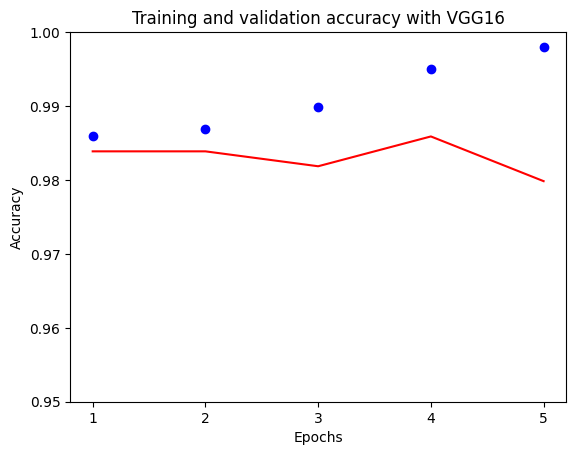

In [26]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
%matplotlib inline

plt.plot(epochs, trn_accs,'bo',label='trn_acc')
plt.plot(epochs, val_accs,'r', label='val_acc')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title("Training and validation accuracy with VGG16")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


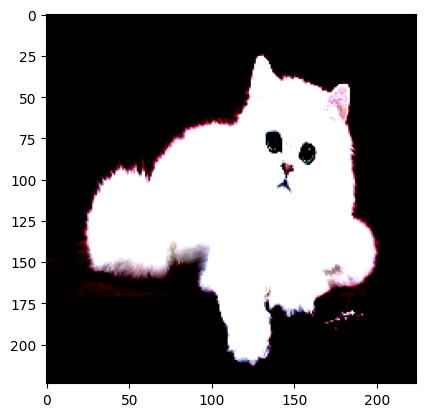

RuntimeError: Input type (double) and bias type (float) should be the same

In [27]:
img = cv2.imread("OIP.jpg")[:, :, ::-1]
img = cv2.resize(img, (224, 224))
img = torch.tensor(img / 255)
img = img.permute(2, 0, 1)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img = normalize(img)

img = img.permute(1,2,0)
plt.imshow(img.numpy())
plt.show()